# Travelling Salesperson Problems

Lucerne University of Applied Sciences and Arts - School of Information Technology

Code adapted from https://developers.google.com/optimization/routing/tsp/tsp

@author: Tobias Mérinat and Marc Pouly

In [2]:
from ortools.constraint_solver import pywrapcp, routing_enums_pb2
from tsp_examples import small, large, gps, randomly, drilling, manhattan

## Display Model Output as Roundtrip

In [3]:
def print_solution(vehicles, cities, manager, routing, solution):
    sum_route_distance = 0
    for vehicle_id in range(vehicles):
        index = routing.Start(vehicle_id)
        plan_output = f"Route for vehicle {vehicle_id}:\n"
        route_distance = 0
        while not routing.IsEnd(index):
            plan_output += f"{cities[manager.IndexToNode(index)]} > "
            previous_index = index
            index = solution.Value(routing.NextVar(index))
            dist = routing.GetArcCostForVehicle(previous_index, index, vehicle_id)
            route_distance += dist
            plan_output += f"({dist}m) "
        plan_output += f"{cities[manager.IndexToNode(index)]}\n"
        plan_output += f"Total distance of vehicle {vehicle_id}: {route_distance} miles\n"
        print(plan_output)
        sum_route_distance += route_distance
    print(f"Total distance over all vehicles: {sum_route_distance}m")

# Simple Example

In [4]:
# Node index of the depot
depot = 0

# The number of available vehicles
vehicles = 1

# City names for printing
names = ["New York", "Los Angeles", "Chicago", "Salt Lake City"]

# Distance table
distances = [
    [0, 2451, 713, 1018],   # New York
    [2451, 0, 1745, 1524],  # Los Angeles
    [713, 1745, 0, 355],    # Chicago
    [1018, 1524, 355, 0]]   # Salt Lake City)

# Create the routing index manager
manager = pywrapcp.RoutingIndexManager(len(names), vehicles, depot)

### Shortest Roundtrip

In [5]:
# Create routing model
routing = pywrapcp.RoutingModel(manager)

# Define distance function
def min_distance_func(ind_from, ind_to):
    return distances[manager.IndexToNode(ind_from)][manager.IndexToNode(ind_to)]

# Turn distance function into callback: This additional step will later allow vehicle specific distance functions, etc.
callback = routing.RegisterTransitCallback(min_distance_func)

# Register callback
routing.SetArcCostEvaluatorOfAllVehicles(callback)

# Solve model
solution = routing.Solve()

if solution:
    print_solution(vehicles, names, manager, routing, solution)
else:
    print("No solution found.")

Route for vehicle 0:
New York > (713m) Chicago > (1745m) Los Angeles > (1524m) Salt Lake City > (1018m) New York
Total distance of vehicle 0: 5000 miles

Total distance over all vehicles: 5000m


### Longest Roundtrip

In [6]:
# Create routing model
routing = pywrapcp.RoutingModel(manager)

# An additive shift larger than any number in the distance matrix
shift = 5000

# Define distance function (negation trick with large constant to avoid negative numbers).
# Note that the addition of the shift is only necessary because OR-Tools does not accept negative distances.
def max_distance_func(ind_from, ind_to):
    return -distances[manager.IndexToNode(ind_from)][manager.IndexToNode(ind_to)] + shift

# Turn distance function into callback
callback = routing.RegisterTransitCallback(max_distance_func)

# Register callback
routing.SetArcCostEvaluatorOfAllVehicles(callback)

# Solve model
solution = routing.Solve()

if solution:
    print_solution(vehicles, names, manager, routing, solution)
    print('But these are negated distances with a large constant added.')
    print('Actual total distance: {}m'.format(-(solution.ObjectiveValue() - len(names) * shift)))
else:
    print("No solution found.")

Route for vehicle 0:
New York > (2549m) Los Angeles > (3255m) Chicago > (4645m) Salt Lake City > (3982m) New York
Total distance of vehicle 0: 14431 miles

Total distance over all vehicles: 14431m
But these are negated distances with a large constant added.
Actual total distance: 5569m


# Larger Example

In [7]:
# Choose between small and large example with multiple vehicles
example2 = large(vehicles=3)

# Create routing model
routing2 = pywrapcp.RoutingModel(example2.manager())

# Turn distance function into callback
callback2 = routing2.RegisterTransitCallback(example2.distance)

# Register callback
routing2.SetArcCostEvaluatorOfAllVehicles(callback2)

solution2 = routing2.Solve()

if solution2:
    print_solution(example2.vehicles, example2.names, example2.manager(), routing2, solution2)
else:
    print("No solution found.")

Route for vehicle 0:
New York > (875m) St. Louis > (547m) Dallas > (225m) Houston > (1017m) Phoenix > (357m) Los Angeles > (403m) San Francisco > (678m) Seattle > (701m) Salt Lake City > (371m) Denver > (700m) Minneapolis > (355m) Chicago > (851m) Boston > (213m) New York
Total distance of vehicle 0: 7293 miles

Route for vehicle 1:
New York > (0m) New York
Total distance of vehicle 1: 0 miles

Route for vehicle 2:
New York > (0m) New York
Total distance of vehicle 2: 0 miles

Total distance over all vehicles: 7293m


# Example with Constraints on visited Cities

In [8]:
# Large example with multiple vehicles
example3 = large(vehicles=3)

# Create routing model
routing3 = pywrapcp.RoutingModel(example3.manager())

# Turn distance function into callback
callback3 = routing3.RegisterTransitCallback(example3.distance)

# Register callback
routing3.SetArcCostEvaluatorOfAllVehicles(callback3)

print(f"The current TSP instance has {example3.size()} cities.")

The current TSP instance has 13 cities.


Add a new dimension that counts the number of visited cities per vehicle. Every transition counts +1.

In [9]:
routing3.AddConstantDimension(1, example3.size(), True, "count")
count = routing3.GetDimensionOrDie("count")

#### No lazy vehicle constraint. Must visit at least one other city than depot.

In [11]:
for i in range(example3.vehicles):
    routing3.solver().Add(count.CumulVar(routing3.End(i)) > 1)  

#### No eager vehicle constraint. No vehicle must visit more than 5 cities.

In [10]:
for i in range(example3.vehicles):
    routing3.solver().Add(count.CumulVar(routing3.End(i)) < 7)  

#### City 2 and 4 (counting starts at 0) must NOT be visited by the same vehicle.

In [11]:
routing3.solver().Add(routing3.VehicleVar(2) != routing3.VehicleVar(4))

print(f"{example3.names[2]} and {example3.names[4]} must not be visited by the same vehicle")

Chicago and Denver must not be visited by the same vehicle


#### City 1 must be visited before city 3 (not necessarily by the same vehicle)

In [12]:
routing3.solver().Add(count.CumulVar(1) < count.CumulVar(3))

print(f"{example3.names[1]} must be visited before {example3.names[3]}")

Los Angeles must be visited before Minneapolis


#### City 6 must be visited right after city 7 (not necessarily by the same vehicle)

In [13]:
routing3.solver().Add(count.CumulVar(7) + 1 == count.CumulVar(6))

print(f"{example3.names[6]} must be visited right after {example3.names[7]}")

Seattle must be visited right after Boston


In [14]:
solution3 = routing3.Solve()

if solution3:
    print_solution(example3.vehicles, example3.names, example3.manager(), routing3, solution3)
else:
    print("No solution found.")

Route for vehicle 0:
New York > (213m) Boston > (851m) Chicago > (713m) New York
Total distance of vehicle 0: 1777 miles

Route for vehicle 1:
New York > (1420m) Houston > (225m) Dallas > (663m) Denver > (371m) Salt Lake City > (987m) Minneapolis > (1018m) New York
Total distance of vehicle 1: 4684 miles

Route for vehicle 2:
New York > (2571m) San Francisco > (678m) Seattle > (959m) Los Angeles > (357m) Phoenix > (1272m) St. Louis > (875m) New York
Total distance of vehicle 2: 6712 miles

Total distance over all vehicles: 13173m


# Example with Capacities

In [12]:
# Large example with multiple vehicles
example4 = large(vehicles=4)

# Create routing model
routing4 = pywrapcp.RoutingModel(example4.manager())

# Turn distance function into callback
dist_callback4 = routing4.RegisterTransitCallback(example4.distance)

# Register callback
routing4.SetArcCostEvaluatorOfAllVehicles(dist_callback4)

# Turn capacity function into callback
demand_callback4 = routing4.RegisterUnaryTransitCallback(example4.demand)

# Add capacity dimension
routing4.AddDimensionWithVehicleCapacity(demand_callback4, 0, example4.capacities, True, "capacity")

solution4 = routing4.Solve()

if solution4:
    print_solution(example4.vehicles, example4.names, example4.manager(), routing4, solution4)
else:
    print("No solution found.")

Route for vehicle 0:
New York > (2145m) Phoenix > (357m) Los Angeles > (831m) Denver > (1631m) New York
Total distance of vehicle 0: 4964 miles

Route for vehicle 1:
New York > (875m) St. Louis > (547m) Dallas > (225m) Houston > (1420m) New York
Total distance of vehicle 1: 3067 miles

Route for vehicle 2:
New York > (213m) Boston > (1123m) Minneapolis > (1395m) Seattle > (678m) San Francisco > (600m) Salt Lake City > (1972m) New York
Total distance of vehicle 2: 5981 miles

Route for vehicle 3:
New York > (713m) Chicago > (713m) New York
Total distance of vehicle 3: 1426 miles

Total distance over all vehicles: 15438m


# Example with Manhattan Distance, Capacities and Path Visualization

In [13]:
# Large example with multiple vehicles
example5 = manhattan(vehicles=4)

# the following code is identical to the one above

# Create routing model
routing5 = pywrapcp.RoutingModel(example5.manager())

# Turn distance function into callback
dist_callback5 = routing5.RegisterTransitCallback(example5.distance)

# Register callback
routing5.SetArcCostEvaluatorOfAllVehicles(dist_callback5)

# Turn capacity function into callback
demand_callback5 = routing5.RegisterUnaryTransitCallback(example5.demand)

# Add capacity dimension
routing5.AddDimensionWithVehicleCapacity(demand_callback5, 0, example5.capacities, True, "capacity")

solution5 = routing5.Solve()

if solution5:
    print_solution(example5.vehicles, example5.names, example5.manager(), routing5, solution5)
else:
    print("No solution found.")

Route for vehicle 0:
0 > (6m) 1 > (2m) 4 > (1m) 3 > (5m) 7 > (2m) 0
Total distance of vehicle 0: 16 miles

Route for vehicle 1:
0 > (4m) 13 > (4m) 15 > (3m) 11 > (1m) 12 > (4m) 0
Total distance of vehicle 1: 16 miles

Route for vehicle 2:
0 > (3m) 8 > (5m) 2 > (3m) 6 > (2m) 5 > (3m) 0
Total distance of vehicle 2: 16 miles

Route for vehicle 3:
0 > (2m) 9 > (3m) 14 > (2m) 16 > (4m) 10 > (5m) 0
Total distance of vehicle 3: 16 miles

Total distance over all vehicles: 64m


Total distance: 64


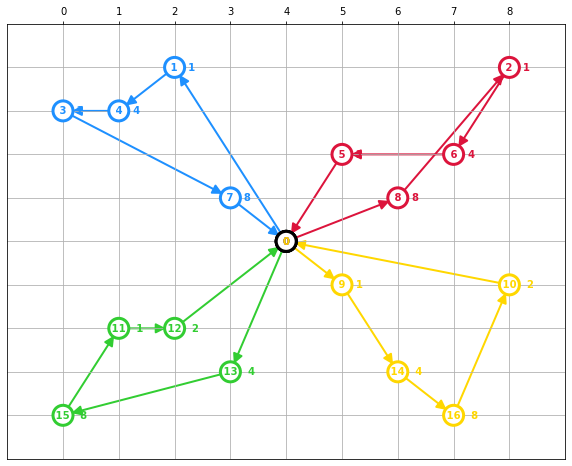

In [14]:
import networkx as nx
from itertools import chain
import matplotlib.pyplot as plt
%matplotlib inline

nodes = example5.nodes
demands = example5.demands
cities = example5.names

def make_ax():
    fig, ax = plt.subplots(figsize=(10,8))
    ax.set_xlim(-1, 9)
    ax.set_ylim(9, -1)
    ax.set_xticks([0,1,2,3,4,5,6,7,8])
    ax.set_yticks([8,7,6,5,4,3,2,1,0])
    ax.xaxis.tick_top()
    ax.grid()
    return ax

def plot_manhattan(all_nodes, tour_colors, graphs=None, all_demands=None):
    ax = make_ax()

    for graph, color in zip(graphs, tour_colors):
        G = nx.DiGraph()
        node_indices = list(set(chain.from_iterable(graph)))
        nodes = [all_nodes[i] for i in node_indices]
        demands = [all_demands[i] for i in node_indices]
        pos = {k:v for k, v in zip(node_indices, nodes)}

        G.add_nodes_from(pos.keys())
        G.add_edges_from(graph)

        color_list = ['black'] + [color] * (len(nodes)-1)
        nx.draw_networkx_nodes(G, pos, ax=ax, node_size=400, node_color='white', edgecolors=color_list, linewidths=3)
        nx.draw_networkx_edges(G, pos, ax=ax, arrows=True, arrowsize=20, width=2, edge_color=color)
        labels = {k:f"     {k}   {d}" for k, d in zip(pos.keys(), demands)}
        labels[0] = 0
        nx.draw_networkx_labels(G, pos, labels=labels, ax=ax,
                                font_color=color, font_size=10, font_weight='bold')
    plt.show()

if solution5:
    graphs = []
    print(f"Total distance: {solution5.ObjectiveValue()}")
    for vehicle_id in range(routing5.vehicles()):
        graph = []
        index = routing5.Start(vehicle_id)  # index of the variable for the starting node
        a = cities[example5.manager().IndexToNode(index)]
        while not routing5.IsEnd(index):
            index = solution5.Value(routing5.NextVar(index))
            b = cities[example5.manager().IndexToNode(index)]
            graph.append((a,b))
            a = cities[example5.manager().IndexToNode(index)]
        graph.append((a, 0))
        graphs.append(graph)
    plot_manhattan(nodes, tour_colors=['dodgerblue', 'limegreen', 'crimson', 'gold'], graphs=graphs, all_demands=demands)